In [4]:
import os
import pandas as pd


data_path = os.path.join( "data.csv")
df = pd.read_csv(data_path)

# Define indices from your pairs
indices = [1972, 4567, 2392, 2963, 2701, 3698, 4391, 866, 517, 4030]

# Compute average of evening/morning b2b + other b2b
avg_b2b = df.loc[indices, ["evening/morning b2b", "other b2b"]].sum(axis=1).mean()

print("Average (evening/morning b2b + other b2b) =", avg_b2b)


Average (evening/morning b2b + other b2b) = 1569.9


Saved plot (curves shifted to start at -1569.9): /home/asj53/LISTEN/LISTEN/avg_with_iter0_baselines_raw.png


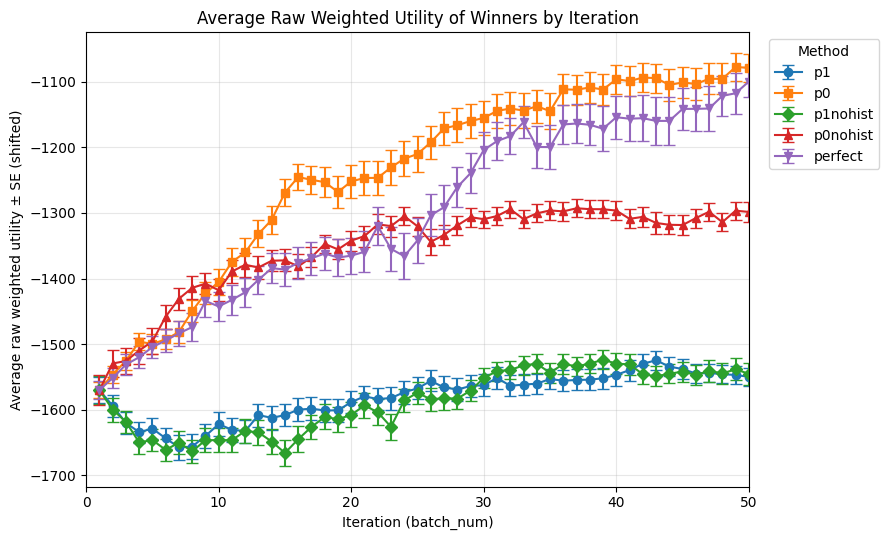

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
WEIGHTS = {
    "conflicts": 000,
    "quints": 0,
    "quads": 0,
    "four in five slots": 0,
    "triple in 24h (no gaps)": 00,
    "triple in same day (no gaps)": 00,
    "three in four slots": 0,
    "evening/morning b2b": -1,
    "other b2b": -1,
    "two in three slots": 0,
}
ROOT = "/home/asj53/LISTEN/LISTEN"
METRICS_CSV_PATH = os.path.join(ROOT, "data.csv")

HIST_A_COL = "idx_a"
HIST_B_COL = "idx_b"
HIST_ITER_COL = "batch_num"
# Load metrics
metrics = pd.read_csv(METRICS_CSV_PATH)
id_col = None
PREF_ONE_MEANS = "B"
# --------------------------
# Helper: figure out who won
# --------------------------
def detect_winner_idx(row):
    cols = row.index

    # Case 1: the file already gives the winner's schedule index
    for c in ["winner_idx", "chosen_idx", "selected_idx"]:
        if c in cols and pd.notna(row[c]):
            return int(row[c])

    # Case 2: boolean "winner_is_a"
    if "winner_is_a" in cols and pd.notna(row["winner_is_a"]):
        win_a = bool(row["winner_is_a"])
        return int(row[HIST_A_COL] if win_a else row[HIST_B_COL])

    # Case 3: string label "winner" in {"A","B"}
    if "winner" in cols and isinstance(row["winner"], str):
        w = row["winner"].strip().upper()
        if w in {"A", "B"}:
            return int(row[HIST_A_COL] if w == "A" else row[HIST_B_COL])

    # Case 4: numeric preference 0/1
    for c in ["pref", "choice", "label", "y"]:
        if c in cols and pd.notna(row[c]):
            v = int(row[c])
            if v not in (0, 1):
                raise ValueError(f"Unexpected value {v} in column '{c}', expected 0/1.")
            if v == 1:
                # 1 means A or B depending on config
                return int(row[HIST_A_COL] if PREF_ONE_MEANS.upper() == "A" else row[HIST_B_COL])
            else:  # v == 0
                return int(row[HIST_B_COL] if PREF_ONE_MEANS.upper() == "A" else row[HIST_A_COL])

    # If we get here we couldn't infer the winner — tell the user what to do.
    raise ValueError(
        "Could not infer winner. Add one of: "
        "[winner_idx], [chosen_idx], [selected_idx], [winner_is_a], "
        "[winner in {'A','B'}], or a 0/1 column like [pref] and set PREF_ONE_MEANS."
    )
for cand in ["schedule_idx", "idx", "schedule_id", "id", "Unnamed: 0"]:
    if cand in metrics.columns:
        id_col = cand
        break
if id_col is None:
    metrics = metrics.reset_index().rename(columns={"index": "schedule_idx"})
    id_col = "schedule_idx"

metrics = metrics.rename(columns={id_col: "schedule_idx"})
metrics["schedule_idx"] = pd.to_numeric(metrics["schedule_idx"], errors="coerce")
metrics = metrics.dropna(subset=["schedule_idx"]).copy()
metrics["schedule_idx"] = metrics["schedule_idx"].astype(int)

metric_cols = list(WEIGHTS.keys())
missing = [c for c in metric_cols if c not in metrics.columns]
if missing:
    raise ValueError(f"metrics.csv is missing required columns: {missing}")

metrics = metrics[["schedule_idx"] + metric_cols]

# Compute utility directly (no normalization)
weight_s = pd.Series(WEIGHTS, dtype=float)
metrics["utility"] = (metrics[metric_cols] * weight_s).sum(axis=1)

# This is the table we'll merge with winners
utility_table = metrics[["schedule_idx", "utility"]].copy()
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def load_avg_curve(file_pattern_func, label):
    """
    Accepts either:
      • an indexed pattern (varies with i), or
      • a glob pattern (e.g., '/path/*.csv') returned for any i.
    Expands globs, dedupes files, and aggregates per-iteration utilities.
    """
    # Build candidate patterns (keeps your existing i-loop behavior)
    candidate_patterns = [file_pattern_func(i) for i in range(0, 52)]

    # Expand globs and collect existing paths
    files = []
    for pat in candidate_patterns:
        if "*" in pat or "?" in pat or "[" in pat:
            files.extend(glob.glob(pat))
        elif os.path.exists(pat):
            files.append(pat)

    # Deduplicate and sort for stability
    files = sorted(set(files))

    if not files:
        print(f"[WARN] No files found for {label}. Skipping.")
        return None, None

    hist_frames = []
    for f in files:
        dfh = pd.read_csv(f)
        
        # Handle iteration column flexibly
        if "iteration" in dfh.columns:
            # If iteration already exists, use it directly
            iter_col = "iteration"
        elif HIST_ITER_COL in dfh.columns:
            # If batch_num exists but not iteration, rename it
            dfh = dfh.rename(columns={HIST_ITER_COL: "iteration"})
            iter_col = "iteration"
        else:
            raise ValueError(f"{os.path.basename(f)} missing both 'iteration' and '{HIST_ITER_COL}' columns")
        
        # Ensure other required columns exist
        for c in (HIST_A_COL, HIST_B_COL):
            if c not in dfh.columns:
                raise ValueError(f"{os.path.basename(f)} missing required column: {c}")

        # Make sure iteration is numeric and 1D
        dfh["iteration"] = pd.to_numeric(dfh["iteration"], errors="coerce")
        dfh = dfh.dropna(subset=["iteration"]).copy()
        dfh["iteration"] = dfh["iteration"].astype(int)
        
        dfh["source_file"] = os.path.basename(f)

        # Robust winner detection
        dfh["schedule_idx"] = dfh.apply(detect_winner_idx, axis=1).astype(int)

        hist_frames.append(dfh[["iteration", "source_file", "schedule_idx"]])

    winners = pd.concat(hist_frames, ignore_index=True)

    # Merge with utilities
    w = winners.merge(utility_table, how="left", on="schedule_idx")
    missing_util = w["utility"].isna().sum()
    if missing_util > 0:
        print(f"[WARN] {label}: {missing_util} winners missing from metrics.csv; "
              f"check schedule_idx alignment.")

    def se(x):
        n = len(x)
        return x.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0

    # Final check to ensure iteration is 1D before groupby
    if "iteration" not in w.columns:
        raise ValueError("iteration column missing after merge")
    
    # Ensure iteration is a simple 1D numeric column
    w["iteration"] = pd.to_numeric(w["iteration"], errors="coerce")
    w = w.dropna(subset=["iteration"])
    w["iteration"] = w["iteration"].astype(int)
    
    avg = (
        w.dropna(subset=["utility"])
         .groupby("iteration", as_index=False)
         .agg(
             avg_winner_utility=("utility", "mean"),
             se_winner_utility=("utility", se),
             n_comparisons=("utility", "size"),
             runs_covered=("source_file", "nunique"),
         )
         .sort_values("iteration")
    )
    return label, avg


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_avg_winner_utility_with_iter0_baseline(
    curves,
    cfgs,
    utility_table,
    out_path,
    title="Average Raw Weighted Utility of Winners by Iteration",
    xlim=None,
    ylim=None,
):
    """
    Plot average winner raw weighted utility ± SE per iteration for multiple methods.
    Each method's curve is vertically shifted so its first-iteration value = START_BASELINE.

    Parameters
    ----------
    curves : list[(str, pd.DataFrame)]
        From load_avg_curve(...). Each df has:
        ['iteration','avg_winner_utility','se_winner_utility','n_comparisons','runs_covered'].

    cfgs : list[(str, callable)]
        [(label, file_pattern_func)], kept for compatibility (not used here).

    utility_table : pd.DataFrame
        Unused in this plotting routine but kept for signature compatibility.

    out_path : str
        Where to save the PNG.

    xlim, ylim : optional axis limits.
    """
    START_BASELINE = -1569.9  # desired y-value for each curve at its first iteration

    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(9, 5.5))

    # Consistent markers per label
    marker_map = {"random": "o", "gp_eubo": "s", "logistic": "D"}
    fallback_markers = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]
    used = 0

    # Sort/clean input and keep only non-empty dataframes
    label_to_df = {
        lbl: df.sort_values("iteration").reset_index(drop=True)
        for lbl, df in curves
        if df is not None and not df.empty
    }

    # Track x-range from actual data (no forced zero to avoid x=0 noise)
    all_iters = []

    # Plot shifted winner curves
    for lbl, df in label_to_df.items():
        marker = marker_map.get(lbl)
        if marker is None:
            marker = fallback_markers[used % len(fallback_markers)]
            used += 1

        # Shift so the first available iteration equals START_BASELINE
        first_iter = int(df["iteration"].min())
        first_val = df.loc[df["iteration"] == first_iter, "avg_winner_utility"].iloc[0]
        shift = START_BASELINE - float(first_val)

        df_plot = df.copy()
        df_plot["avg_winner_utility"] = df_plot["avg_winner_utility"] + shift

        plt.errorbar(
            df_plot["iteration"],
            df_plot["avg_winner_utility"],
            yerr=df_plot["se_winner_utility"],
            fmt=f"{marker}-",
            capsize=4,
            label=lbl,
        )

        all_iters.extend(df_plot["iteration"].tolist())

    plt.xlabel("Iteration (batch_num)")
    plt.ylabel("Average raw weighted utility ± SE (shifted)")
    plt.title(title if title else "Average Raw Weighted Utility of Winners by Iteration")
    plt.grid(True, alpha=0.3)

    # Use data-driven x-limits unless overridden
    if xlim is not None:
        plt.xlim(*xlim)
    elif all_iters:
        plt.xlim(min(all_iters), max(all_iters))

    if ylim is not None:
        plt.ylim(*ylim)

    plt.legend(title="Method", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    print(f"Saved plot (curves shifted to start at {START_BASELINE}): {out_path}")

# Define the config for the two methods
cfgs = [
    ("p1",  lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt1historyTrue.csv"
    )),
    ("p0", lambda i: os.path.join(
        ROOT, f"logs/abig_batch_pref_history_LLM_logistic_run{i}_prompt0_historyTrue.csv"
    )),
    ("p1nohist", lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt1historyFalse.csv"
    )),
    ("p0nohist", lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt0historyFalse.csv"
    )),
     ("perfect", lambda i: os.path.join(
        ROOT, f"logs/cheapbig_batch_pref_history_util_logistic_run{i}_prompt0_historyFalse.csv"
    )),

]

# Build curves
curves = []
for label, fn in cfgs:
    lbl, df = load_avg_curve(fn, label)  # load_avg_curve will merge with utility_table
    if df is not None:
        curves.append((lbl, df))

# Now curves only contains gp_eubo and logistic

out_path = os.path.join(ROOT, "avg_with_iter0_baselines_raw.png")
plot_avg_winner_utility_with_iter0_baseline(
    curves,          # from load_avg_curve (built using utility_table with raw weighted sum)
    cfgs,            # [(label, file_pattern_func), ...]
    utility_table,   # ['schedule_idx','utility'] computed with your raw WEIGHTS
    out_path,
    xlim=(0, 50),
)


In [ ]:
import os
import glob
import pandas as pd

ROOT = "/home/asj53/LISTEN/LISTEN"
DATA_PATH = os.path.join(ROOT, "data.csv")
df_metrics = pd.read_csv(DATA_PATH)

HIST_A_COL = "idx_a"
HIST_B_COL = "idx_b"
HIST_ITER_COL = "batch_num"

def detect_winner_idx(row):
    if "winner" in row and pd.notna(row["winner"]):
        w = str(row["winner"]).strip().upper()
        if w == "A":
            return int(row[HIST_A_COL])
        elif w == "B":
            return int(row[HIST_B_COL])
    raise ValueError("No valid winner column found")

cfgs = [
    ("p1",  lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt1historyTrue.csv"
    )),
    ("p0", lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt0historyTrue.csv"
    )),
    ("p1nohist", lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt1historyFalse.csv"
    )),
    ("p0nohist", lambda i: os.path.join(
        ROOT, f"logs/nightbig_batch_pref_historylogistic{i}prompt0historyFalse.csv"
    )),
    ("perfect", lambda i: os.path.join(
        ROOT, f"logs/b2b_history*.csv"
    )),
]

def expand_files(pattern_func):
    files = []
    for i in range(0, 52):
        pat = pattern_func(i)
        if "*" in pat:
            files.extend(glob.glob(pat))
        elif os.path.exists(pat):
            files.append(pat)
    return sorted(set(files))

for label, pattern_func in cfgs:
    files = expand_files(pattern_func)
    if not files:
        print(f"{label}: No files found")
        continue

    final_winner_indices = []

    for f in files:
        hist = pd.read_csv(f)

        # normalize iteration column
        if "iteration" not in hist.columns and HIST_ITER_COL in hist.columns:
            hist = hist.rename(columns={HIST_ITER_COL: "iteration"})

        # last iteration's winners
        max_iter = hist["iteration"].max()
        last_iter_rows = hist[hist["iteration"] == max_iter].copy()
        last_iter_rows["winner_index"] = last_iter_rows.apply(detect_winner_idx, axis=1)

        final_winner_indices.extend(last_iter_rows["winner_index"].tolist())

    if final_winner_indices:
        # Just like your example — treat these as row indices in df_metrics
        avg_b2b = df_metrics.loc[final_winner_indices, ["evening/morning b2b", "other b2b"]].sum(axis=1).mean()
        print(f"{label}: Final iteration avg (evening/morning b2b + other b2b) = {avg_b2b:.2f}")
    else:
        print(f"{label}: No final winners found")



p1: Final iteration avg (evening/morning b2b + other b2b) = 1579.36
p0: Final iteration avg (evening/morning b2b + other b2b) = 1022.09
p1nohist: Final iteration avg (evening/morning b2b + other b2b) = 1574.80
p0nohist: Final iteration avg (evening/morning b2b + other b2b) = 1262.76
perfect: Final iteration avg (evening/morning b2b + other b2b) = 1045.22
